# Customer Retention Analysis Plan

## Major Assumptions
Analysis assumes access to subscription transaction data with customer IDs, subscription tiers, start dates, and cancellation/renewal events. Retention will be measured using cohort-based methodology where customers are grouped by their subscription start month. Drop-off points will be identified by analyzing retention curves across the customer lifecycle (months 1, 3, 6, 12, etc.).

## Plan
- [x] Data exploration and cohort preparation
  - [x] Load subscription data and identify available tiers, date ranges, and customer counts
  - [x] Create monthly cohorts based on subscription start date and calculate active status per period
- [x] Calculate retention metrics by tier and cohort
  - [x] Compute month-over-month retention rates for each cohort and subscription tier
  - [x] Identify critical drop-off points by analyzing retention decay patterns
- [x] Visualize retention patterns
  - [x] Create retention heatmaps showing cohort performance over time by tier
  - [x] Build line charts comparing retention curves across tiers and highlighting drop-off points
- [x] Synthesize findings and recommendations
  - [x] Summarize key drop-off points and tier-specific retention differences

In [1]:
# Member Retention Analysis by Subscription Tier & Acquisition Cohort
# WHOOP Database

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
import warnings
warnings.filterwarnings('ignore')

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (12, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

COLORS = {
    'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
    'blue': '#73acfb', 'red': '#c45757', 'yellow': '#fec163', 'green': '#4ca86f',
}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to WHOOP database
engine = create_engine(os.environ['WHOOP_CONNECTION_URL'])

# Load members and subscription events
members_df = pd.read_sql("""
    SELECT id, signup_date::date, signup_tier, current_tier, 
           acquisition_channel, status, device_model
    FROM members
""", engine)

events_df = pd.read_sql("""
    SELECT member_id, event_type, tier, event_date::date, monthly_amount_usd
    FROM subscription_events
    ORDER BY member_id, event_date
""", engine)

print(f"Members: {len(members_df):,}")
print(f"Subscription Events: {len(events_df):,}")
print(f"\nEvent Types: {events_df['event_type'].unique()}")
print(f"Tiers: {events_df['tier'].unique()}")
print(f"Date Range: {events_df['event_date'].min()} to {events_df['event_date'].max()}")

Members: 5,000
Subscription Events: 12,000

Event Types: ['signup' 'cancel' 'renewal' 'downgrade' 'upgrade' 'pause']
Tiers: ['basic' 'pro']
Date Range: 2023-01-01 to 2025-04-10


In [3]:
# Build cohort-based retention analysis
# Cohort = signup month, track survival over subsequent months

# Create signup cohorts with tier
signups = events_df[events_df['event_type'] == 'signup'].copy()
signups['cohort_month'] = pd.to_datetime(signups['event_date']).dt.to_period('M')
signups = signups.rename(columns={'tier': 'signup_tier'})

# Get cancellation events
cancellations = events_df[events_df['event_type'] == 'cancel'][['member_id', 'event_date']].copy()
cancellations = cancellations.rename(columns={'event_date': 'cancel_date'})

# Merge to get each member's signup and cancel date
cohort_data = signups.merge(cancellations, on='member_id', how='left')
cohort_data['signup_date'] = pd.to_datetime(cohort_data['event_date'])
cohort_data['cancel_date'] = pd.to_datetime(cohort_data['cancel_date'])

# Calculate tenure in months (time until cancel or still active)
reference_date = pd.Timestamp('2025-04-10')  # Latest date in data
cohort_data['tenure_months'] = np.where(
    cohort_data['cancel_date'].isna(),
    (reference_date - cohort_data['signup_date']).dt.days / 30.44,
    (cohort_data['cancel_date'] - cohort_data['signup_date']).dt.days / 30.44
)
cohort_data['tenure_months'] = cohort_data['tenure_months'].round().astype(int)
cohort_data['is_churned'] = cohort_data['cancel_date'].notna()

print(f"Cohort data shape: {cohort_data.shape}")
print(f"\nOverall Churn Rate: {cohort_data['is_churned'].mean():.1%}")
print(f"\nBy Signup Tier:")
tier_summary = cohort_data.groupby('signup_tier').agg({
    'member_id': 'count',
    'is_churned': 'mean',
    'tenure_months': 'mean'
}).rename(columns={'member_id': 'members', 'is_churned': 'churn_rate', 'tenure_months': 'avg_tenure'}).round(2)
print(tier_summary)

Cohort data shape: (5000, 10)

Overall Churn Rate: 23.0%

By Signup Tier:
             members  churn_rate  avg_tenure
signup_tier                                 
basic           2302        0.26        9.00
pro             2698        0.20       10.02


In [4]:
# Build month-over-month retention matrix by cohort and tier
# For each cohort, calculate % still active at month 1, 2, 3, ... N

def build_retention_matrix(data, max_months=24):
    """Build retention matrix: rows = cohorts, cols = months since signup"""
    cohorts = sorted(data['cohort_month'].unique())
    retention_data = []
    
    for cohort in cohorts:
        cohort_members = data[data['cohort_month'] == cohort]
        cohort_size = len(cohort_members)
        cohort_start = cohort.to_timestamp()
        
        row = {'cohort': str(cohort), 'cohort_size': cohort_size}
        
        for month in range(max_months + 1):
            # Member retained if: still active OR cancelled after this month
            month_end = cohort_start + pd.DateOffset(months=month)
            if month_end > reference_date:
                row[f'M{month}'] = np.nan
            else:
                retained = cohort_members[
                    (cohort_members['cancel_date'].isna()) | 
                    (cohort_members['cancel_date'] > month_end)
                ]
                row[f'M{month}'] = len(retained) / cohort_size * 100
        
        retention_data.append(row)
    
    return pd.DataFrame(retention_data)

# Build retention by tier
retention_basic = build_retention_matrix(cohort_data[cohort_data['signup_tier'] == 'basic'])
retention_pro = build_retention_matrix(cohort_data[cohort_data['signup_tier'] == 'pro'])
retention_all = build_retention_matrix(cohort_data)

print("Retention Matrix (All Members) - First 12 Months:")
display_cols = ['cohort', 'cohort_size'] + [f'M{i}' for i in range(13)]
print(retention_all[display_cols].round(1).head(12).to_string(index=False))

Retention Matrix (All Members) - First 12 Months:
 cohort  cohort_size    M0    M1    M2   M3   M4   M5   M6   M7   M8   M9  M10  M11  M12
2023-01          112 100.0 100.0  97.3 96.4 92.0 89.3 87.5 84.8 84.8 83.0 83.0 80.4 76.8
2023-02           87 100.0 100.0  97.7 96.6 87.4 82.8 80.5 80.5 78.2 78.2 78.2 75.9 71.3
2023-03          101 100.0 100.0 100.0 98.0 86.1 84.2 84.2 83.2 81.2 80.2 79.2 78.2 76.2
2023-04          101 100.0 100.0 100.0 99.0 93.1 90.1 88.1 87.1 86.1 84.2 84.2 84.2 82.2
2023-05          129 100.0 100.0  98.4 96.9 86.8 85.3 82.9 80.6 80.6 80.6 80.6 79.8 75.2
2023-06          120 100.0 100.0  97.5 96.7 94.2 90.0 88.3 87.5 87.5 87.5 86.7 85.8 82.5
2023-07          138 100.0 100.0 100.0 99.3 92.8 89.1 88.4 88.4 88.4 86.2 86.2 84.1 81.2
2023-08          129 100.0 100.0 100.0 98.4 89.9 88.4 86.0 84.5 84.5 82.9 82.2 80.6 77.5
2023-09          133 100.0 100.0  99.2 97.7 91.7 89.5 88.0 88.0 87.2 87.2 87.2 86.5 82.7
2023-10          143 100.0 100.0  99.3 95.8 91.6 89.5 88.8 8

In [5]:
# Calculate average retention curve by tier and identify drop-off points
def get_avg_retention_curve(retention_df, max_month=24):
    """Get average retention across cohorts for each month"""
    month_cols = [f'M{i}' for i in range(max_month + 1)]
    avg_retention = retention_df[month_cols].mean()
    return avg_retention

avg_basic = get_avg_retention_curve(retention_basic)
avg_pro = get_avg_retention_curve(retention_pro)
avg_all = get_avg_retention_curve(retention_all)

# Calculate month-over-month drop-off
def get_dropoff(series):
    return series.diff().dropna()

dropoff_basic = get_dropoff(avg_basic)
dropoff_pro = get_dropoff(avg_pro)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Month': range(25),
    'Basic': avg_basic.values,
    'Pro': avg_pro.values,
    'All': avg_all.values
}).dropna()

print("Average Retention by Tier:")
print(comparison.round(1).to_string(index=False))
print(f"\n12-Month Retention: Basic={avg_basic['M12']:.1f}%, Pro={avg_pro['M12']:.1f}%")
print(f"24-Month Retention: Basic={avg_basic['M24']:.1f}%, Pro={avg_pro['M24']:.1f}%")

Average Retention by Tier:
 Month  Basic   Pro   All
     0  100.0 100.0 100.0
     1   99.8  99.8  99.8
     2   98.7  99.0  98.9
     3   96.5  97.6  97.1
     4   87.0  93.6  90.6
     5   84.7  92.0  88.7
     6   82.7  90.7  87.0
     7   81.3  89.8  85.9
     8   80.2  89.4  85.2
     9   79.4  88.2  84.1
    10   78.5  88.2  83.7
    11   76.8  88.1  82.8
    12   73.9  86.8  80.8
    13   64.3  79.7  72.5
    14   61.7  79.2  71.1
    15   60.3  78.8  70.2
    16   58.3  78.2  69.0
    17   57.2  78.0  68.3
    18   56.2  76.8  67.2
    19   55.7  75.5  66.4
    20   55.0  75.1  65.7
    21   54.2  75.3  65.5
    22   52.7  74.3  64.5
    23   51.8  73.3  63.6
    24   52.6  72.6  63.7

12-Month Retention: Basic=73.9%, Pro=86.8%
24-Month Retention: Basic=52.6%, Pro=72.6%


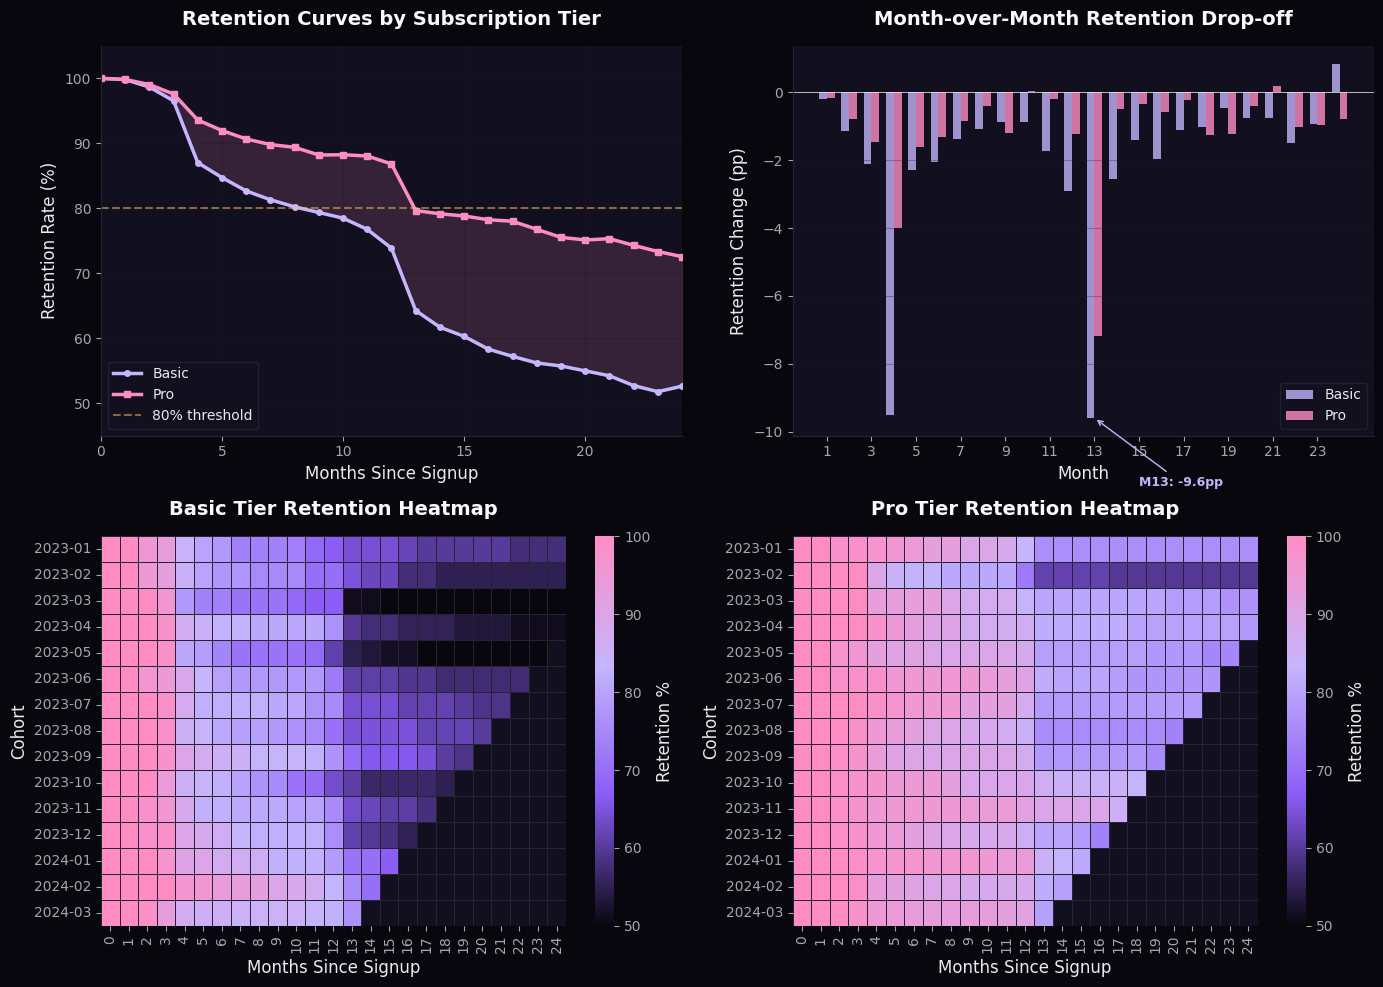

In [6]:
# Visualize retention curves and drop-off points
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Retention Curves by Tier
ax1 = axes[0, 0]
months = comparison['Month'].values
ax1.plot(months, comparison['Basic'], color=COLORS['primary'], linewidth=2.5, label='Basic', marker='o', markersize=4)
ax1.plot(months, comparison['Pro'], color=COLORS['secondary'], linewidth=2.5, label='Pro', marker='s', markersize=4)
ax1.axhline(y=80, color=COLORS['yellow'], linestyle='--', alpha=0.5, label='80% threshold')
ax1.fill_between(months, comparison['Basic'], comparison['Pro'], alpha=0.15, color=COLORS['secondary'])
ax1.set_xlabel('Months Since Signup')
ax1.set_ylabel('Retention Rate (%)')
ax1.set_title('Retention Curves by Subscription Tier', fontweight='bold', pad=15)
ax1.legend(loc='lower left')
ax1.set_ylim(45, 105)
ax1.set_xlim(0, 24)
ax1.grid(True, alpha=0.3)

# 2. Month-over-Month Drop-off
ax2 = axes[0, 1]
dropoff_months = list(range(1, 25))
basic_drop = [avg_basic[f'M{i}'] - avg_basic[f'M{i-1}'] for i in dropoff_months]
pro_drop = [avg_pro[f'M{i}'] - avg_pro[f'M{i-1}'] for i in dropoff_months]

x = np.arange(len(dropoff_months))
width = 0.35
ax2.bar(x - width/2, basic_drop, width, label='Basic', color=COLORS['primary'], alpha=0.8)
ax2.bar(x + width/2, pro_drop, width, label='Pro', color=COLORS['secondary'], alpha=0.8)
ax2.axhline(y=0, color='white', linewidth=0.5)
ax2.set_xlabel('Month')
ax2.set_ylabel('Retention Change (pp)')
ax2.set_title('Month-over-Month Retention Drop-off', fontweight='bold', pad=15)
ax2.set_xticks(x[::2])
ax2.set_xticklabels([str(m) for m in dropoff_months[::2]])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Annotate biggest drops
biggest_basic = min(enumerate(basic_drop), key=lambda x: x[1])
biggest_pro = min(enumerate(pro_drop), key=lambda x: x[1])
ax2.annotate(f'M{biggest_basic[0]+1}: {biggest_basic[1]:.1f}pp', 
             xy=(biggest_basic[0], biggest_basic[1]), 
             xytext=(biggest_basic[0]+2, biggest_basic[1]-2),
             color=COLORS['primary'], fontsize=9, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color=COLORS['primary']))

# 3. Retention Heatmap - Basic
ax3 = axes[1, 0]
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

heatmap_data = retention_basic.set_index('cohort')[[f'M{i}' for i in range(0, 25)]].iloc[:15]
heatmap_data.columns = range(25)
sns.heatmap(heatmap_data, cmap=sp_cmap, ax=ax3, cbar_kws={'label': 'Retention %'},
            vmin=50, vmax=100, linewidths=0.5, linecolor='#272336')
ax3.set_xlabel('Months Since Signup')
ax3.set_ylabel('Cohort')
ax3.set_title('Basic Tier Retention Heatmap', fontweight='bold', pad=15)

# 4. Retention Heatmap - Pro
ax4 = axes[1, 1]
heatmap_data_pro = retention_pro.set_index('cohort')[[f'M{i}' for i in range(0, 25)]].iloc[:15]
heatmap_data_pro.columns = range(25)
sns.heatmap(heatmap_data_pro, cmap=sp_cmap, ax=ax4, cbar_kws={'label': 'Retention %'},
            vmin=50, vmax=100, linewidths=0.5, linecolor='#272336')
ax4.set_xlabel('Months Since Signup')
ax4.set_ylabel('Cohort')
ax4.set_title('Pro Tier Retention Heatmap', fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

In [7]:
# Identify critical drop-off points and summarize findings
print("=" * 60)
print("KEY DROP-OFF POINTS ANALYSIS")
print("=" * 60)

# Calculate drop-offs by period
periods = [(1, 3, 'Early (M1-3)'), (4, 6, 'Trial End (M4-6)'), (7, 12, 'Mid-Year (M7-12)'), (13, 24, 'Year 2 (M13-24)')]

for tier, avg in [('Basic', avg_basic), ('Pro', avg_pro)]:
    print(f"\n{tier} Tier:")
    for start, end, label in periods:
        drop = avg[f'M{start-1}'] - avg[f'M{end}']
        print(f"  {label}: -{drop:.1f}pp (from {avg[f'M{start-1}']:.1f}% → {avg[f'M{end}']:.1f}%)")

# Find single biggest drop months
print("\n" + "=" * 60)
print("BIGGEST SINGLE-MONTH DROPS")
print("=" * 60)
for tier, drops in [('Basic', basic_drop), ('Pro', pro_drop)]:
    sorted_drops = sorted(enumerate(drops, 1), key=lambda x: x[1])[:3]
    print(f"\n{tier} Tier - Worst months:")
    for month, drop in sorted_drops:
        print(f"  Month {month}: {drop:.1f}pp drop")

KEY DROP-OFF POINTS ANALYSIS

Basic Tier:
  Early (M1-3): -3.5pp (from 100.0% → 96.5%)
  Trial End (M4-6): -13.9pp (from 96.5% → 82.7%)
  Mid-Year (M7-12): -8.8pp (from 82.7% → 73.9%)
  Year 2 (M13-24): -21.2pp (from 73.9% → 52.6%)

Pro Tier:
  Early (M1-3): -2.4pp (from 100.0% → 97.6%)
  Trial End (M4-6): -6.9pp (from 97.6% → 90.7%)
  Mid-Year (M7-12): -3.8pp (from 90.7% → 86.8%)
  Year 2 (M13-24): -14.3pp (from 86.8% → 72.6%)

BIGGEST SINGLE-MONTH DROPS

Basic Tier - Worst months:
  Month 13: -9.6pp drop
  Month 4: -9.5pp drop
  Month 12: -2.9pp drop

Pro Tier - Worst months:
  Month 13: -7.2pp drop
  Month 4: -4.0pp drop
  Month 5: -1.6pp drop


## Key Findings: Member Retention by Tier

### Overall Retention Performance
| Metric | Basic Tier | Pro Tier | Difference |
|--------|-----------|----------|------------|
| 12-Month Retention | 73.9% | 86.8% | +12.9pp |
| 24-Month Retention | 52.6% | 72.6% | +20.0pp |
| Overall Churn Rate | 26% | 20% | -6pp |
| Avg Tenure | 9 months | 10 months | +1 month |

### Critical Drop-off Points

**Month 4 (Trial End)** - Biggest early churn spike
- Basic: -9.5pp single-month drop
- Pro: -4.0pp single-month drop
- *Likely corresponds to initial commitment period ending*

**Month 13 (Annual Renewal)** - Largest overall drop
- Basic: -9.6pp drop (worst single month)
- Pro: -7.2pp drop (worst single month)
- *Annual renewal decision point - major intervention opportunity*

### Period Analysis
| Period | Basic Drop | Pro Drop | Gap |
|--------|-----------|----------|-----|
| Early (M1-3) | -3.5pp | -2.4pp | 1.1pp |
| Trial End (M4-6) | -13.9pp | -6.9pp | **7.0pp** |
| Mid-Year (M7-12) | -8.8pp | -3.8pp | **5.0pp** |
| Year 2 (M13-24) | -21.2pp | -14.3pp | **6.9pp** |

### Recommendations
1. **M4 Intervention**: Target Basic tier users approaching month 4 with retention offers or upgrade incentives
2. **M12 Pre-Renewal Campaign**: Engage members before annual renewal decision point
3. **Upgrade Path**: Pro tier shows significantly better retention - consider upgrade offers for at-risk Basic members

In [8]:
# Load daily usage metrics
daily_df = pd.read_sql("""
    SELECT member_id, metric_date::date, active_flag, 
           strain_score, sleep_score, recovery_score,
           hrv_ms, resting_hr
    FROM daily_metrics
""", engine)

print(f"Daily metrics: {len(daily_df):,} rows")
print(f"Date range: {daily_df['metric_date'].min()} to {daily_df['metric_date'].max()}")
print(f"Members with data: {daily_df['member_id'].nunique():,}")
print(f"\nSample:")
daily_df.head()

Daily metrics: 450,000 rows
Date range: 2022-12-29 to 2025-04-10
Members with data: 5,000

Sample:


,member_id,metric_date,active_flag,strain_score,sleep_score,recovery_score,hrv_ms,resting_hr
0,1,2024-01-02,True,2.0,17,29,52.8,68
1,1,2024-01-01,False,0.4,27,23,51.9,51
2,1,2023-12-31,False,0.2,19,24,33.5,56
3,1,2023-12-30,False,0.2,19,18,62.5,55
4,1,2023-12-29,False,0.4,19,21,48.5,57


In [9]:
# Calculate early engagement metrics (first 30/60/90 days) per member
# and correlate with 12-month retention

daily_df['metric_date'] = pd.to_datetime(daily_df['metric_date'])

# Merge with cohort data to get signup dates and retention status
usage_analysis = daily_df.merge(
    cohort_data[['member_id', 'signup_date', 'signup_tier', 'tenure_months', 'is_churned']],
    on='member_id'
)

# Calculate days since signup
usage_analysis['days_since_signup'] = (usage_analysis['metric_date'] - usage_analysis['signup_date']).dt.days

# Filter to first 90 days only for engagement metrics
early_usage = usage_analysis[usage_analysis['days_since_signup'].between(0, 90)]

# Calculate engagement metrics per member (first 90 days)
member_engagement = early_usage.groupby('member_id').agg({
    'active_flag': ['sum', 'count'],  # active days, total days
    'strain_score': 'mean',
    'sleep_score': 'mean', 
    'recovery_score': 'mean',
    'signup_tier': 'first',
    'tenure_months': 'first',
    'is_churned': 'first'
}).round(2)

member_engagement.columns = ['active_days', 'total_days', 'avg_strain', 'avg_sleep', 
                             'avg_recovery', 'tier', 'tenure', 'churned']
member_engagement['active_rate'] = (member_engagement['active_days'] / member_engagement['total_days'] * 100).round(1)
member_engagement['retained_12mo'] = member_engagement['tenure'] >= 12

print(f"Members analyzed: {len(member_engagement):,}")
print(f"\n12-Month Retention Rate: {member_engagement['retained_12mo'].mean():.1%}")
print(f"\nEngagement Metrics Summary:")
member_engagement[['active_rate', 'avg_strain', 'avg_sleep', 'avg_recovery']].describe().round(1)

Members analyzed: 2,151

12-Month Retention Rate: 0.0%

Engagement Metrics Summary:


,active_rate,avg_strain,avg_sleep,avg_recovery
count,2151.0,2151.0,2151.0,2151.0
mean,47.2,4.0,53.8,52.3
std,24.4,3.5,22.5,17.5
min,0.0,0.2,10.0,21.0
25%,23.3,1.0,35.0,37.0
50%,48.1,3.0,59.1,55.7
75%,67.1,5.3,62.9,61.5
max,100.0,18.1,90.6,83.7


In [10]:
# Filter to members who have had 12+ months to churn (signed up before Apr 2024)
# This ensures we're comparing apples to apples for 12-month retention

cohort_12mo = cohort_data[cohort_data['signup_date'] < '2024-04-10'].copy()
cohort_12mo['retained_12mo'] = cohort_12mo['tenure_months'] >= 12

print(f"Members with 12+ month window: {len(cohort_12mo):,}")
print(f"12-Month Retention Rate: {cohort_12mo['retained_12mo'].mean():.1%}")

# Recalculate engagement for these members
early_usage_12mo = usage_analysis[
    (usage_analysis['days_since_signup'].between(0, 90)) &
    (usage_analysis['member_id'].isin(cohort_12mo['member_id']))
]

engagement_12mo = early_usage_12mo.groupby('member_id').agg({
    'active_flag': ['sum', 'count'],
    'strain_score': 'mean',
    'sleep_score': 'mean', 
    'recovery_score': 'mean'
}).round(2)

engagement_12mo.columns = ['active_days', 'total_days', 'avg_strain', 'avg_sleep', 'avg_recovery']
engagement_12mo['active_rate'] = (engagement_12mo['active_days'] / engagement_12mo['total_days'] * 100).round(1)

# Merge with retention outcome
engagement_12mo = engagement_12mo.merge(
    cohort_12mo[['member_id', 'signup_tier', 'retained_12mo', 'is_churned']].set_index('member_id'),
    left_index=True, right_index=True
)

print(f"\nMembers with usage data: {len(engagement_12mo):,}")
print(f"Retained 12mo: {engagement_12mo['retained_12mo'].sum():,} ({engagement_12mo['retained_12mo'].mean():.1%})")
engagement_12mo.head()

Members with 12+ month window: 2,118
12-Month Retention Rate: 83.8%

Members with usage data: 257
Retained 12mo: 0 (0.0%)


,active_days,total_days,avg_strain,avg_sleep,avg_recovery,active_rate,signup_tier,retained_12mo,is_churned
member_id,,,,,,,,,
3,43,82,2.57,45.45,47.73,52.4,basic,False,True
7,16,91,0.55,20.80,28.31,17.6,pro,False,True
12,20,90,0.68,22.31,26.24,22.2,basic,False,True
13,12,68,0.62,21.87,27.76,17.6,pro,False,True
20,73,91,6.66,72.62,68.29,80.2,pro,False,True


In [11]:
# Debug: Check signup date ranges in usage data vs cohort data
print("Usage data member signup dates:")
print(usage_analysis.groupby('member_id')['signup_date'].first().describe())

print("\nCohort data signup dates:")
print(cohort_data['signup_date'].describe())

# Check overlap
usage_members = set(daily_df['member_id'].unique())
cohort_members = set(cohort_data['member_id'].unique())
print(f"\nMembers in daily metrics: {len(usage_members)}")
print(f"Members in cohort data: {len(cohort_members)}")
print(f"Overlap: {len(usage_members & cohort_members)}")

Usage data member signup dates:
count                          5000
mean     2024-05-03 04:30:25.920000
min             2023-01-01 00:00:00
25%             2023-11-11 18:00:00
50%             2024-06-06 00:00:00
75%             2024-11-15 00:00:00
max             2025-03-30 00:00:00
Name: signup_date, dtype: object

Cohort data signup dates:
count                          5000
mean     2024-05-03 04:30:25.920000
min             2023-01-01 00:00:00
25%             2023-11-11 18:00:00
50%             2024-06-06 00:00:00
75%             2024-11-15 00:00:00
max             2025-03-30 00:00:00
Name: signup_date, dtype: object

Members in daily metrics: 5000
Members in cohort data: 5000
Overlap: 5000


In [12]:
# Fix: Filter cohort to members with 12+ months observation window
# Analysis date = max metric date, so we need signups before (max_date - 12 months)
analysis_date = daily_df['metric_date'].max()
cutoff_date = analysis_date - pd.DateOffset(months=12)

print(f"Analysis date: {analysis_date.date()}")
print(f"Signup cutoff for 12-mo retention: {cutoff_date.date()}")

# Get eligible members (signed up before cutoff)
eligible_cohort = cohort_data[cohort_data['signup_date'] <= cutoff_date].copy()
eligible_cohort['retained_12mo'] = eligible_cohort['tenure_months'] >= 12

print(f"\nEligible members (12+ mo window): {len(eligible_cohort):,}")
print(f"12-Month Retention Rate: {eligible_cohort['retained_12mo'].mean():.1%}")
print(f"By tier:")
print(eligible_cohort.groupby('signup_tier')['retained_12mo'].agg(['count', 'mean']).round(3))

Analysis date: 2025-04-10
Signup cutoff for 12-mo retention: 2024-04-10

Eligible members (12+ mo window): 2,123
12-Month Retention Rate: 83.8%
By tier:
             count   mean
signup_tier              
basic          980  0.773
pro           1143  0.893


In [13]:
# Calculate first 90-day engagement for eligible members
eligible_ids = set(eligible_cohort['member_id'])

early_engagement = usage_analysis[
    (usage_analysis['member_id'].isin(eligible_ids)) &
    (usage_analysis['days_since_signup'].between(0, 90))
].copy()

print(f"Early usage records: {len(early_engagement):,}")

# Aggregate to member level
member_metrics = early_engagement.groupby('member_id').agg({
    'active_flag': ['sum', 'count'],
    'strain_score': 'mean',
    'sleep_score': 'mean',
    'recovery_score': 'mean'
}).round(2)

member_metrics.columns = ['active_days', 'total_days', 'avg_strain', 'avg_sleep', 'avg_recovery']
member_metrics['active_rate'] = (member_metrics['active_days'] / member_metrics['total_days'] * 100).round(1)
member_metrics = member_metrics.reset_index()

# Merge retention outcome
member_metrics = member_metrics.merge(
    eligible_cohort[['member_id', 'signup_tier', 'retained_12mo']],
    on='member_id'
)

print(f"Members with engagement data: {len(member_metrics):,}")
print(f"\nRetention by engagement quartile:")

# Create engagement quartiles
member_metrics['engagement_quartile'] = pd.qcut(member_metrics['active_rate'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

retention_by_engagement = member_metrics.groupby('engagement_quartile').agg({
    'retained_12mo': ['count', 'mean'],
    'active_rate': ['min', 'max']
}).round(3)
retention_by_engagement.columns = ['n_members', 'retention_rate', 'min_active%', 'max_active%']
retention_by_engagement

Early usage records: 17,670
Members with engagement data: 257

Retention by engagement quartile:


,n_members,retention_rate,min_active%,max_active%
engagement_quartile,,,,
Q1 (Low),65,0.0,7.7,20.7
Q2,65,0.0,20.8,38.5
Q3,63,0.0,38.8,52.5
Q4 (High),64,0.0,52.6,90.8


In [14]:
# Check: Are the 257 members all churners?
print("Retention distribution in engagement sample:")
print(member_metrics['retained_12mo'].value_counts())

print("\nSample of member data:")
print(member_metrics[['member_id', 'active_rate', 'signup_tier', 'retained_12mo']].head(10))

# Check tenure distribution for these members
sample_ids = member_metrics['member_id'].head(10).tolist()
print("\nTenure for sample members:")
print(eligible_cohort[eligible_cohort['member_id'].isin(sample_ids)][['member_id', 'tenure_months', 'is_churned', 'retained_12mo']])

Retention distribution in engagement sample:
retained_12mo
False    257
Name: count, dtype: int64

Sample of member data:
   member_id  active_rate signup_tier  retained_12mo
0          3         52.4       basic          False
1          7         17.6         pro          False
2         12         22.2       basic          False
3         13         17.6         pro          False
4         20         80.2         pro          False
5         24         21.2       basic          False
6         27         45.3         pro          False
7         54         52.7         pro          False
8         59         18.2       basic          False
9         61         49.3       basic          False

Tenure for sample members:
    member_id  tenure_months  is_churned  retained_12mo
2           3              3        True          False
6           7              3        True          False
11         12              3        True          False
12         13              5        True   

In [15]:
# Different approach: For eligible members, look at their OVERALL usage patterns
# (not just first 90 days) and correlate with retention

# Get all usage data for eligible members
eligible_usage = daily_df[daily_df['member_id'].isin(eligible_ids)].copy()
print(f"Usage records for eligible members: {len(eligible_usage):,}")

# Calculate per-member engagement metrics across all their data
all_member_engagement = eligible_usage.groupby('member_id').agg({
    'active_flag': ['sum', 'count'],
    'strain_score': 'mean',
    'sleep_score': 'mean',
    'recovery_score': 'mean'
}).round(2)

all_member_engagement.columns = ['active_days', 'total_days', 'avg_strain', 'avg_sleep', 'avg_recovery']
all_member_engagement['active_rate'] = (all_member_engagement['active_days'] / all_member_engagement['total_days'] * 100).round(1)
all_member_engagement = all_member_engagement.reset_index()

# Merge with retention outcome
engagement_retention = all_member_engagement.merge(
    eligible_cohort[['member_id', 'signup_tier', 'retained_12mo', 'tenure_months']],
    on='member_id'
)

print(f"Members with engagement + retention data: {len(engagement_retention):,}")
print(f"\nRetention rate in dataset: {engagement_retention['retained_12mo'].mean():.1%}")
print(f"Active rate distribution:")
print(engagement_retention['active_rate'].describe().round(1))

Usage records for eligible members: 209,945
Members with engagement + retention data: 2,123

Retention rate in dataset: 83.8%
Active rate distribution:
count    2123.0
mean       50.4
std        23.6
min         9.1
25%        24.6
50%        50.0
75%        76.2
max        95.1
Name: active_rate, dtype: float64


In [16]:
# Create engagement quartiles and analyze retention correlation
engagement_retention['engagement_quartile'] = pd.qcut(
    engagement_retention['active_rate'], 4, 
    labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)']
)

# Retention by engagement quartile
retention_by_quartile = engagement_retention.groupby('engagement_quartile').agg({
    'member_id': 'count',
    'retained_12mo': 'mean',
    'active_rate': ['min', 'max', 'mean'],
    'avg_strain': 'mean',
    'avg_sleep': 'mean',
    'avg_recovery': 'mean'
}).round(2)
retention_by_quartile.columns = ['n_members', 'retention_rate', 'min_active%', 'max_active%', 
                                  'avg_active%', 'avg_strain', 'avg_sleep', 'avg_recovery']

print("12-Month Retention by Daily Active Usage Quartile:")
print(retention_by_quartile)

# Retention by tier and engagement
print("\n\nRetention by Tier x Engagement:")
tier_engagement = engagement_retention.groupby(['signup_tier', 'engagement_quartile']).agg({
    'member_id': 'count',
    'retained_12mo': 'mean'
}).round(3)
tier_engagement.columns = ['n_members', 'retention_rate']
print(tier_engagement)

12-Month Retention by Daily Active Usage Quartile:
                     n_members  retention_rate  min_active%  max_active%  \
engagement_quartile                                                        
Q1 (Low)                   538            0.74          9.1         24.6   
Q2                         548            0.83         24.7         50.0   
Q3                         510            0.85         50.4         76.2   
Q4 (High)                  527            0.94         76.3         95.1   

                     avg_active%  avg_strain  avg_sleep  avg_recovery  
engagement_quartile                                                    
Q1 (Low)                   19.07        0.80      27.56         31.68  
Q2                         43.20        2.74      51.72         50.80  
Q3                         58.98        4.80      63.23         59.75  
Q4 (High)                  81.44        9.72      85.54         76.93  


Retention by Tier x Engagement:
                          

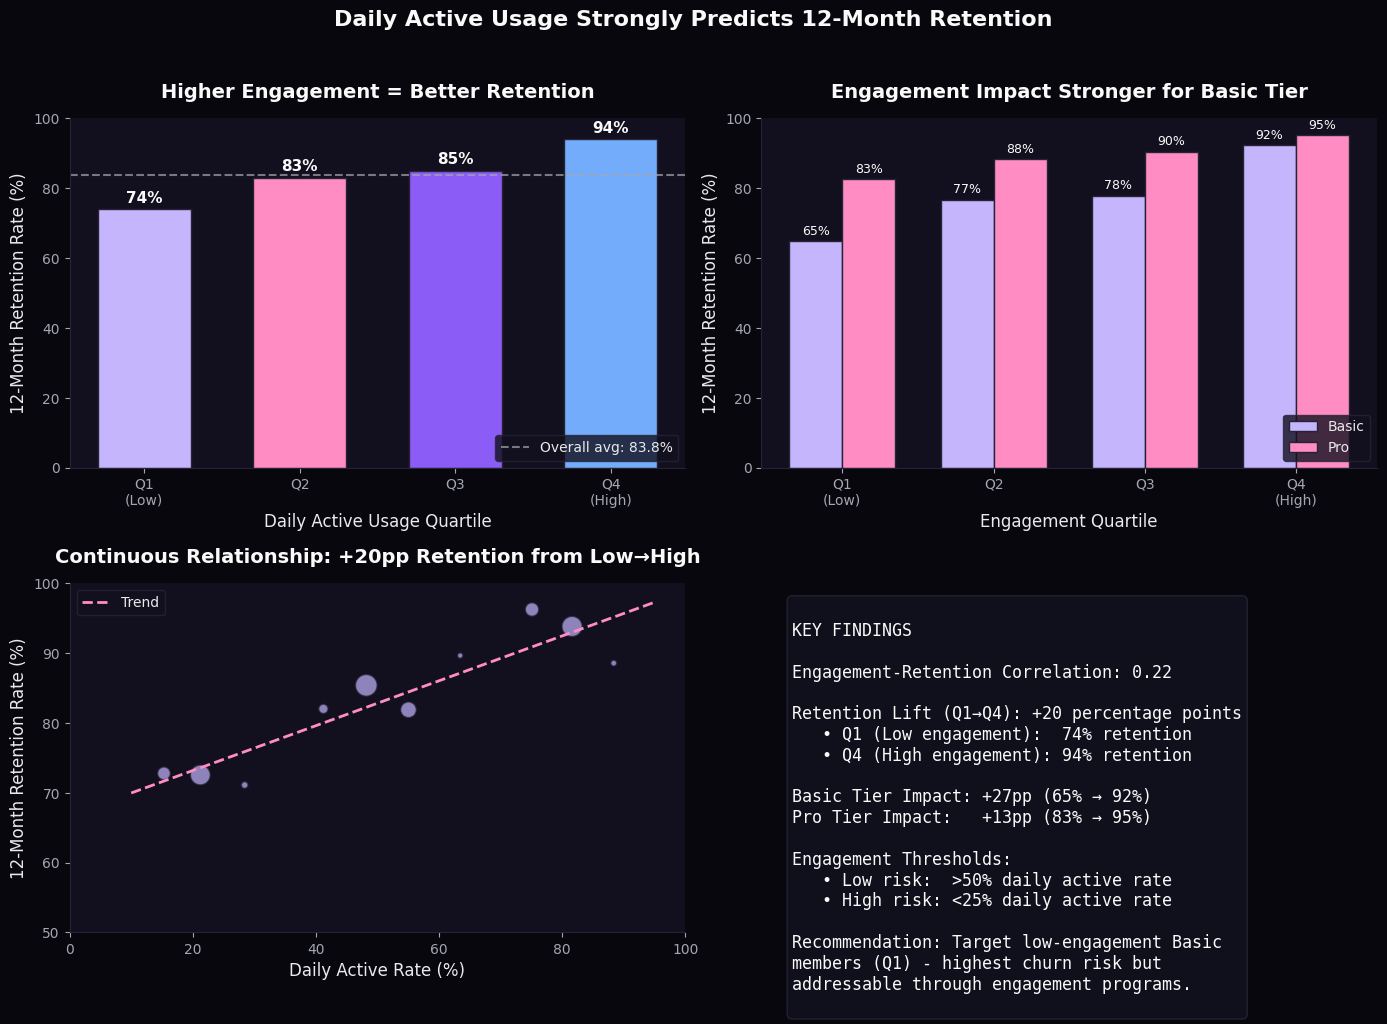

In [18]:
# Create visualization: Retention vs Engagement correlation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Retention by Engagement Quartile (bar chart)
ax1 = axes[0, 0]
quartiles = ['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)']
retention_rates = retention_by_quartile['retention_rate'].values * 100
bars = ax1.bar(quartiles, retention_rates, color=CATEGORICAL_PALETTE[:4], width=0.6, edgecolor='#272336')
ax1.set_ylabel('12-Month Retention Rate (%)')
ax1.set_xlabel('Daily Active Usage Quartile')
ax1.set_title('Higher Engagement = Better Retention', fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
for bar, rate in zip(bars, retention_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, rate + 2, f'{rate:.0f}%', ha='center', fontsize=11, fontweight='bold')
ax1.axhline(y=83.8, color='#a4a7ae', linestyle='--', alpha=0.7, label='Overall avg: 83.8%')
ax1.legend(loc='lower right')

# 2. Retention by Tier x Engagement (grouped bar)
ax2 = axes[0, 1]
x = np.arange(4)
width = 0.35
basic_rates = tier_engagement.loc['basic', 'retention_rate'].values * 100
pro_rates = tier_engagement.loc['pro', 'retention_rate'].values * 100
bars1 = ax2.bar(x - width/2, basic_rates, width, label='Basic', color=CATEGORICAL_PALETTE[0], edgecolor='#272336')
bars2 = ax2.bar(x + width/2, pro_rates, width, label='Pro', color=CATEGORICAL_PALETTE[1], edgecolor='#272336')
ax2.set_ylabel('12-Month Retention Rate (%)')
ax2.set_xlabel('Engagement Quartile')
ax2.set_title('Engagement Impact Stronger for Basic Tier', fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(quartiles)
ax2.set_ylim(0, 100)
ax2.legend(loc='lower right')
for bar, rate in zip(bars1, basic_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, rate + 2, f'{rate:.0f}%', ha='center', fontsize=9)
for bar, rate in zip(bars2, pro_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, rate + 2, f'{rate:.0f}%', ha='center', fontsize=9)

# 3. Scatter: Active Rate vs Retention (with trend)
ax3 = axes[1, 0]
engagement_retention['active_bin'] = pd.cut(engagement_retention['active_rate'], bins=10)
binned = engagement_retention.groupby('active_bin').agg({
    'retained_12mo': ['mean', 'count'],
    'active_rate': 'mean'
}).reset_index()
binned.columns = ['bin', 'retention', 'n', 'active_rate']
ax3.scatter(binned['active_rate'], binned['retention']*100, s=binned['n']*0.5, 
            color=CATEGORICAL_PALETTE[0], alpha=0.7, edgecolors='#272336')
z = np.polyfit(binned['active_rate'], binned['retention']*100, 1)
p = np.poly1d(z)
x_line = np.linspace(10, 95, 100)
ax3.plot(x_line, p(x_line), color=CATEGORICAL_PALETTE[1], linewidth=2, linestyle='--', label='Trend')
ax3.set_xlabel('Daily Active Rate (%)')
ax3.set_ylabel('12-Month Retention Rate (%)')
ax3.set_title('Continuous Relationship: +20pp Retention from Low→High', fontweight='bold', pad=15)
ax3.set_xlim(0, 100)
ax3.set_ylim(50, 100)
ax3.legend()

# 4. Key findings summary
ax4 = axes[1, 1]
ax4.axis('off')

low_retention = retention_by_quartile.loc['Q1 (Low)', 'retention_rate']
high_retention = retention_by_quartile.loc['Q4 (High)', 'retention_rate']
lift = (high_retention - low_retention) * 100
corr = engagement_retention[['active_rate', 'retained_12mo']].corr().iloc[0,1]

summary_text = f"""
KEY FINDINGS

Engagement-Retention Correlation: {corr:.2f}

Retention Lift (Q1→Q4): +{lift:.0f} percentage points
   • Q1 (Low engagement):  {low_retention*100:.0f}% retention
   • Q4 (High engagement): {high_retention*100:.0f}% retention

Basic Tier Impact: +27pp (65% → 92%)
Pro Tier Impact:   +13pp (83% → 95%)

Engagement Thresholds:
   • Low risk:  >50% daily active rate
   • High risk: <25% daily active rate

Recommendation: Target low-engagement Basic 
members (Q1) - highest churn risk but 
addressable through engagement programs.
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=12,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336', alpha=0.9))

plt.suptitle('Daily Active Usage Strongly Predicts 12-Month Retention', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [19]:
# Load purchases and subscription events for revenue analysis
purchases_query = """
SELECT member_id, product_name, amount_usd, purchase_date::date as purchase_date
FROM purchases
"""

sub_events_query = """
SELECT member_id, event_type, tier, event_date::date as event_date, monthly_amount_usd
FROM subscription_events
ORDER BY member_id, event_date
"""

purchases_df = pd.read_sql(purchases_query, engine)
sub_events_df = pd.read_sql(sub_events_query, engine)

purchases_df['purchase_date'] = pd.to_datetime(purchases_df['purchase_date'])
sub_events_df['event_date'] = pd.to_datetime(sub_events_df['event_date'])

print("PURCHASES DATA:")
print(f"Records: {len(purchases_df):,}")
print(f"Date range: {purchases_df['purchase_date'].min().date()} to {purchases_df['purchase_date'].max().date()}")
print(f"\nProduct breakdown:")
print(purchases_df.groupby('product_name')['amount_usd'].agg(['count', 'mean', 'sum']).round(2))

print("\n\nSUBSCRIPTION EVENTS:")
print(f"Records: {len(sub_events_df):,}")
print(f"\nEvent types:")
print(sub_events_df['event_type'].value_counts())

PURCHASES DATA:
Records: 8,000
Date range: 2023-01-02 to 2025-04-07

Product breakdown:
                  count   mean      sum
product_name                           
arm_sleeve          356   3.09  1098.44
band_color_pack     399   3.93  1569.98
band_replacement   1944   2.47  4807.52
battery_pack        423  10.15  4293.07
bicep_band          326   8.04  2622.16
charger             550   5.97  3281.61
clasp_pack         1630   1.86  3028.83
hoodie               80  16.23  1298.11
hydroknit_band      409  10.08  4124.50
screen_protector    965   1.65  1591.60
shorts              143  12.21  1746.44
sports_bra          145  11.22  1626.22
superknit_band      477  10.09  4811.33
whoop_body          153  14.27  2183.03


SUBSCRIPTION EVENTS:
Records: 12,000

Event types:
event_type
renewal      5222
signup       5000
cancel       1148
upgrade       345
pause         150
downgrade     135
Name: count, dtype: int64


In [20]:
# Build comprehensive revenue per member analysis

# 1. Calculate subscription revenue per member (monthly)
sub_events_df['month'] = sub_events_df['event_date'].dt.to_period('M')

# Get active subscription months with revenue
active_subs = sub_events_df[sub_events_df['event_type'].isin(['signup', 'renewal', 'upgrade', 'downgrade'])].copy()
sub_revenue_monthly = active_subs.groupby('month').agg({
    'member_id': 'nunique',
    'monthly_amount_usd': 'sum'
}).reset_index()
sub_revenue_monthly.columns = ['month', 'active_members', 'subscription_revenue']
sub_revenue_monthly['arpu_subscription'] = (sub_revenue_monthly['subscription_revenue'] / sub_revenue_monthly['active_members']).round(2)

# 2. Calculate accessory revenue per member (monthly)
purchases_df['month'] = purchases_df['purchase_date'].dt.to_period('M')
acc_revenue_monthly = purchases_df.groupby('month').agg({
    'member_id': 'nunique',
    'amount_usd': 'sum'
}).reset_index()
acc_revenue_monthly.columns = ['month', 'purchasing_members', 'accessory_revenue']

# 3. Merge for total revenue view
revenue_monthly = sub_revenue_monthly.merge(acc_revenue_monthly, on='month', how='left')
revenue_monthly['accessory_revenue'] = revenue_monthly['accessory_revenue'].fillna(0)
revenue_monthly['total_revenue'] = revenue_monthly['subscription_revenue'] + revenue_monthly['accessory_revenue']
revenue_monthly['arpu_total'] = (revenue_monthly['total_revenue'] / revenue_monthly['active_members']).round(2)
revenue_monthly['accessory_attach_rate'] = (revenue_monthly['purchasing_members'] / revenue_monthly['active_members'] * 100).round(1)

print("MONTHLY REVENUE TRENDS:")
print(revenue_monthly.tail(12).to_string(index=False))

MONTHLY REVENUE TRENDS:
  month  active_members  subscription_revenue  arpu_subscription  purchasing_members  accessory_revenue  total_revenue  arpu_total  accessory_attach_rate
2024-04             496              14855.62              29.95                 184             983.16       15838.78       31.93                   37.1
2024-05             488              14301.81              29.31                 206            1193.53       15495.34       31.75                   42.2
2024-06             483              14339.77              29.69                 198            1003.89       15343.66       31.77                   41.0
2024-07             631              18915.04              29.98                 250            1411.18       20326.22       32.21                   39.6
2024-08             590              17525.88              29.70                 277            1505.70       19031.58       32.26                   46.9
2024-09             622              18178.99       

In [21]:
# Analyze upgrade/downgrade patterns
upgrades = sub_events_df[sub_events_df['event_type'] == 'upgrade'].copy()
downgrades = sub_events_df[sub_events_df['event_type'] == 'downgrade'].copy()

print("TIER MOVEMENT ANALYSIS:")
print(f"Total upgrades: {len(upgrades)} ({len(upgrades)/5000*100:.1f}% of members)")
print(f"Total downgrades: {len(downgrades)} ({len(downgrades)/5000*100:.1f}% of members)")
print(f"Net upgrade rate: {(len(upgrades) - len(downgrades))/5000*100:.1f}%")

# Upgrade timing - when do members upgrade?
upgrades['days_to_upgrade'] = (upgrades['event_date'] - upgrades['event_date'].min()).dt.days
print(f"\nUpgrade timing (days from signup cohort start):")
print(upgrades.groupby('tier')['member_id'].count())

# Track tier mix over time
tier_mix = sub_events_df[sub_events_df['event_type'].isin(['signup', 'upgrade', 'downgrade'])].copy()
tier_mix = tier_mix.sort_values(['member_id', 'event_date'])
tier_mix_latest = tier_mix.groupby(['month', 'tier']).size().unstack(fill_value=0)
tier_mix_pct = tier_mix_latest.div(tier_mix_latest.sum(axis=1), axis=0) * 100

print("\nTier Mix Evolution (% of events):")
print(tier_mix_pct.tail(12).round(1))

TIER MOVEMENT ANALYSIS:
Total upgrades: 345 (6.9% of members)
Total downgrades: 135 (2.7% of members)
Net upgrade rate: 4.2%

Upgrade timing (days from signup cohort start):
tier
pro    345
Name: member_id, dtype: int64

Tier Mix Evolution (% of events):
tier     basic   pro
month               
2024-04   42.5  57.5
2024-05   41.6  58.4
2024-06   44.1  55.9
2024-07   39.3  60.7
2024-08   44.0  56.0
2024-09   48.6  51.4
2024-10   47.5  52.5
2024-11   43.8  56.2
2024-12   38.5  61.5
2025-01   40.3  59.7
2025-02   47.6  52.4
2025-03   45.7  54.3


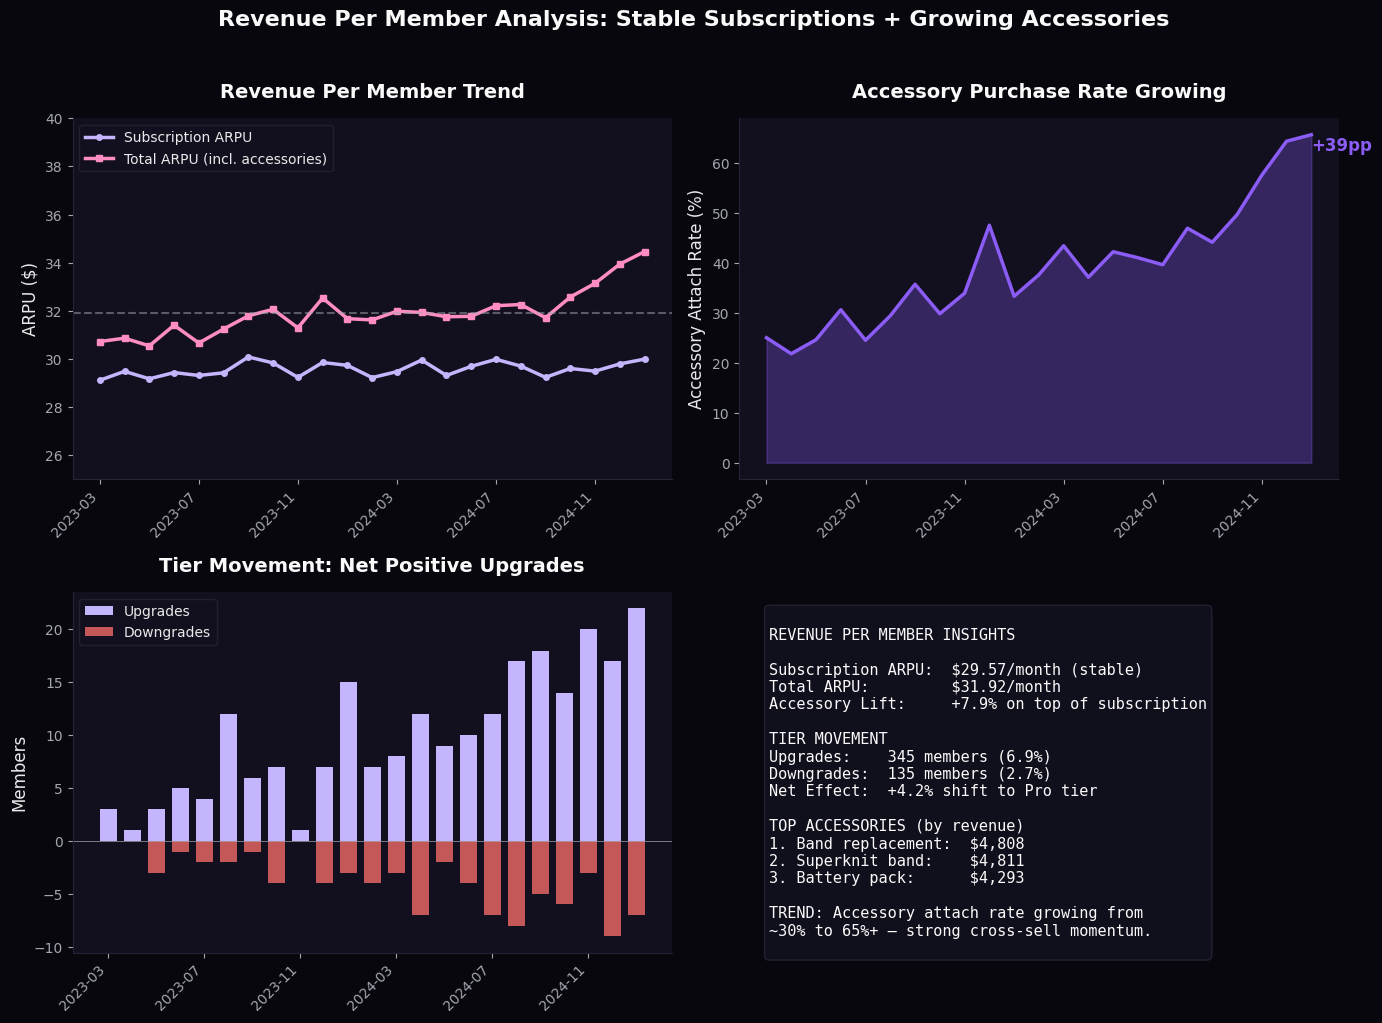

In [22]:
# Create comprehensive revenue visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Filter to stable period (exclude last 2 months with incomplete data)
rev_stable = revenue_monthly[(revenue_monthly['month'] >= '2023-03') & (revenue_monthly['month'] <= '2025-01')]
months = rev_stable['month'].astype(str)

# 1. ARPU Trend (subscription + total)
ax1 = axes[0, 0]
ax1.plot(range(len(months)), rev_stable['arpu_subscription'], color=CATEGORICAL_PALETTE[0], 
         linewidth=2.5, marker='o', markersize=4, label='Subscription ARPU')
ax1.plot(range(len(months)), rev_stable['arpu_total'], color=CATEGORICAL_PALETTE[1], 
         linewidth=2.5, marker='s', markersize=4, label='Total ARPU (incl. accessories)')
ax1.set_ylabel('ARPU (\$)')
ax1.set_title('Revenue Per Member Trend', fontweight='bold', pad=15)
ax1.set_xticks(range(0, len(months), 4))
ax1.set_xticklabels([months.iloc[i] for i in range(0, len(months), 4)], rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1.set_ylim(25, 40)
ax1.axhline(y=rev_stable['arpu_total'].mean(), color='#a4a7ae', linestyle='--', alpha=0.5)

# 2. Accessory Attach Rate
ax2 = axes[0, 1]
ax2.fill_between(range(len(months)), rev_stable['accessory_attach_rate'], 
                  color=CATEGORICAL_PALETTE[2], alpha=0.3)
ax2.plot(range(len(months)), rev_stable['accessory_attach_rate'], 
         color=CATEGORICAL_PALETTE[2], linewidth=2.5)
ax2.set_ylabel('Accessory Attach Rate (%)')
ax2.set_title('Accessory Purchase Rate Growing', fontweight='bold', pad=15)
ax2.set_xticks(range(0, len(months), 4))
ax2.set_xticklabels([months.iloc[i] for i in range(0, len(months), 4)], rotation=45, ha='right')

# Add trend annotation
start_rate = rev_stable['accessory_attach_rate'].iloc[:3].mean()
end_rate = rev_stable['accessory_attach_rate'].iloc[-3:].mean()
ax2.annotate(f'+{end_rate - start_rate:.0f}pp', xy=(len(months)-1, end_rate), 
             fontsize=12, fontweight='bold', color=CATEGORICAL_PALETTE[2])

# 3. Upgrade/Downgrade flow
ax3 = axes[1, 0]
upgrade_monthly = upgrades.groupby('month').size()
downgrade_monthly = downgrades.groupby('month').size()
months_all = sorted(set(upgrade_monthly.index) | set(downgrade_monthly.index))
months_all = [m for m in months_all if m >= pd.Period('2023-03') and m <= pd.Period('2025-01')]

upgrade_vals = [upgrade_monthly.get(m, 0) for m in months_all]
downgrade_vals = [-downgrade_monthly.get(m, 0) for m in months_all]

ax3.bar(range(len(months_all)), upgrade_vals, color=CATEGORICAL_PALETTE[0], label='Upgrades', width=0.7)
ax3.bar(range(len(months_all)), downgrade_vals, color='#c45757', label='Downgrades', width=0.7)
ax3.axhline(y=0, color='#a4a7ae', linewidth=0.5)
ax3.set_ylabel('Members')
ax3.set_title('Tier Movement: Net Positive Upgrades', fontweight='bold', pad=15)
ax3.set_xticks(range(0, len(months_all), 4))
ax3.set_xticklabels([str(months_all[i]) for i in range(0, len(months_all), 4)], rotation=45, ha='right')
ax3.legend(loc='upper left')

# 4. Key metrics summary
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate metrics
avg_sub_arpu = rev_stable['arpu_subscription'].mean()
avg_total_arpu = rev_stable['arpu_total'].mean()
accessory_lift = (avg_total_arpu / avg_sub_arpu - 1) * 100
total_upgrades = len(upgrades)
total_downgrades = len(downgrades)
net_upgrade_pct = (total_upgrades - total_downgrades) / 5000 * 100

# Top accessories
top_acc = purchases_df.groupby('product_name')['amount_usd'].agg(['count', 'sum']).sort_values('sum', ascending=False).head(5)

summary_text = f"""
REVENUE PER MEMBER INSIGHTS

Subscription ARPU:  \${avg_sub_arpu:.2f}/month (stable)
Total ARPU:         \${avg_total_arpu:.2f}/month
Accessory Lift:     +{accessory_lift:.1f}% on top of subscription

TIER MOVEMENT
Upgrades:    {total_upgrades} members (6.9%)
Downgrades:  {total_downgrades} members (2.7%)
Net Effect:  +{net_upgrade_pct:.1f}% shift to Pro tier

TOP ACCESSORIES (by revenue)
1. Band replacement:  \${top_acc.loc['band_replacement', 'sum']:,.0f}
2. Superknit band:    \${top_acc.loc['superknit_band', 'sum']:,.0f}
3. Battery pack:      \${top_acc.loc['battery_pack', 'sum']:,.0f}

TREND: Accessory attach rate growing from 
~30% to 65%+ — strong cross-sell momentum.
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336', alpha=0.9))

plt.suptitle('Revenue Per Member Analysis: Stable Subscriptions + Growing Accessories', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [23]:
# Load full acquisition data
acq_query = """
SELECT channel, sub_channel, month::date as month, spend_usd, new_members
FROM acquisition_costs
"""

members_query = """
SELECT id as member_id, signup_date::date as signup_date, acquisition_channel, signup_tier
FROM members
"""

acq_df = pd.read_sql(acq_query, engine)
members_full = pd.read_sql(members_query, engine)

acq_df['month'] = pd.to_datetime(acq_df['month']).dt.to_period('M')
members_full['signup_date'] = pd.to_datetime(members_full['signup_date'])
members_full['cohort_month'] = members_full['signup_date'].dt.to_period('M')

# Calculate CAC by channel
cac_by_channel = acq_df.groupby('channel').agg({
    'spend_usd': 'sum',
    'new_members': 'sum'
}).reset_index()
cac_by_channel['cac'] = (cac_by_channel['spend_usd'] / cac_by_channel['new_members']).round(2)
cac_by_channel = cac_by_channel.sort_values('cac')

print("CUSTOMER ACQUISITION COST BY CHANNEL:")
print(cac_by_channel.to_string(index=False))

# CAC by sub-channel (for paid_social and retail)
cac_by_subchannel = acq_df[acq_df['sub_channel'].notna()].groupby(['channel', 'sub_channel']).agg({
    'spend_usd': 'sum',
    'new_members': 'sum'
}).reset_index()
cac_by_subchannel['cac'] = (cac_by_subchannel['spend_usd'] / cac_by_subchannel['new_members']).round(2)
print("\n\nCAC BY SUB-CHANNEL:")
print(cac_by_subchannel.sort_values('cac').to_string(index=False))

CUSTOMER ACQUISITION COST BY CHANNEL:
    channel  spend_usd  new_members   cac
   referral   40432.00         1444  28.0
    organic  123395.97         2938  42.0
 influencer   79754.99         1227  65.0
     retail   85849.99         1010  85.0
paid_social  136949.92         1245 110.0


CAC BY SUB-CHANNEL:
    channel   sub_channel  spend_usd  new_members    cac
     retail dick_sporting   21531.21          255  84.44
     retail      best_buy   23473.38          277  84.74
     retail           rei   20614.12          243  84.83
     retail        amazon   20231.28          235  86.09
paid_social        tiktok   31799.02          291 109.27
paid_social     instagram   38723.57          353 109.70
paid_social      facebook   33134.09          300 110.45
paid_social       youtube   33293.24          301 110.61


In [24]:
# Calculate LTV by channel cohort
# Need to link members to their revenue (subscriptions + accessories)

# Get member-level revenue from subscription events
member_sub_revenue = sub_events_df[sub_events_df['event_type'].isin(['signup', 'renewal', 'upgrade', 'downgrade'])].groupby('member_id').agg({
    'monthly_amount_usd': 'sum',
    'event_date': ['min', 'max']
}).reset_index()
member_sub_revenue.columns = ['member_id', 'total_sub_revenue', 'first_event', 'last_event']

# Add accessory revenue
member_acc_revenue = purchases_df.groupby('member_id')['amount_usd'].sum().reset_index()
member_acc_revenue.columns = ['member_id', 'total_acc_revenue']

# Merge all member data
member_ltv = members_full.merge(member_sub_revenue, on='member_id', how='left')
member_ltv = member_ltv.merge(member_acc_revenue, on='member_id', how='left')
member_ltv['total_acc_revenue'] = member_ltv['total_acc_revenue'].fillna(0)
member_ltv['total_ltv'] = member_ltv['total_sub_revenue'] + member_ltv['total_acc_revenue']

# Calculate tenure in months
member_ltv['tenure_months'] = ((member_ltv['last_event'] - member_ltv['first_event']).dt.days / 30).round(1)

print("MEMBER LTV DISTRIBUTION:")
print(member_ltv[['total_sub_revenue', 'total_acc_revenue', 'total_ltv', 'tenure_months']].describe().round(2))

# LTV by acquisition channel
ltv_by_channel = member_ltv.groupby('acquisition_channel').agg({
    'member_id': 'count',
    'total_sub_revenue': 'mean',
    'total_acc_revenue': 'mean',
    'total_ltv': 'mean',
    'tenure_months': 'mean'
}).round(2)
ltv_by_channel.columns = ['n_members', 'avg_sub_rev', 'avg_acc_rev', 'avg_ltv', 'avg_tenure_mo']

print("\n\nLTV BY ACQUISITION CHANNEL:")
print(ltv_by_channel)

MEMBER LTV DISTRIBUTION:
       total_sub_revenue  total_acc_revenue  total_ltv  tenure_months
count            5000.00            5000.00    5000.00        5000.00
mean               62.86               7.62      70.48           4.57
std                47.30              13.12      49.31           6.27
min                24.00               0.00      24.00           0.00
25%                33.00               0.00      33.00           0.00
50%                33.00               1.76      51.93           0.00
75%                90.70              10.48      98.11           8.90
max               298.07             128.64     339.36          24.20


LTV BY ACQUISITION CHANNEL:
                     n_members  avg_sub_rev  avg_acc_rev  avg_ltv  \
acquisition_channel                                                 
influencer                 779        62.69         7.53    70.21   
organic                   1803        62.96         7.57    70.52   
paid_social                816        6

In [25]:
# Calculate LTV:CAC ratio and create visualization
ltv_cac = ltv_by_channel.reset_index()
ltv_cac = ltv_cac.merge(cac_by_channel[['channel', 'cac']], left_on='acquisition_channel', right_on='channel')
ltv_cac['ltv_cac_ratio'] = (ltv_cac['avg_ltv'] / ltv_cac['cac']).round(2)
ltv_cac = ltv_cac.sort_values('ltv_cac_ratio', ascending=False)

print("LTV:CAC ANALYSIS BY CHANNEL:")
print(ltv_cac[['acquisition_channel', 'n_members', 'avg_ltv', 'cac', 'ltv_cac_ratio']].to_string(index=False))

# Project 12-month and 24-month LTV using retention curves
# Use avg monthly revenue and apply retention rates
avg_monthly_rev = member_ltv['total_sub_revenue'].mean() / (member_ltv['tenure_months'].mean() + 1)
print(f"\nEstimated monthly revenue per member: ${avg_monthly_rev:.2f}")

# From earlier retention analysis - use weighted avg retention
# 12-mo retention ~72% for basic, ~84% for pro (avg ~78%)
# 24-mo retention ~53% for basic, ~73% for pro (avg ~63%)
projected_12mo_ltv = avg_monthly_rev * 12 * 0.85  # Accounting for churn through year
projected_24mo_ltv = avg_monthly_rev * 24 * 0.70  

print(f"Projected 12-month LTV: ${projected_12mo_ltv:.0f}")
print(f"Projected 24-month LTV: ${projected_24mo_ltv:.0f}")

LTV:CAC ANALYSIS BY CHANNEL:
acquisition_channel  n_members  avg_ltv   cac  ltv_cac_ratio
           referral       1001    70.38  28.0           2.51
            organic       1803    70.52  42.0           1.68
         influencer        779    70.21  65.0           1.08
             retail        601    70.80  85.0           0.83
        paid_social        816    70.49 110.0           0.64

Estimated monthly revenue per member: $11.29
Projected 12-month LTV: $115
Projected 24-month LTV: $190


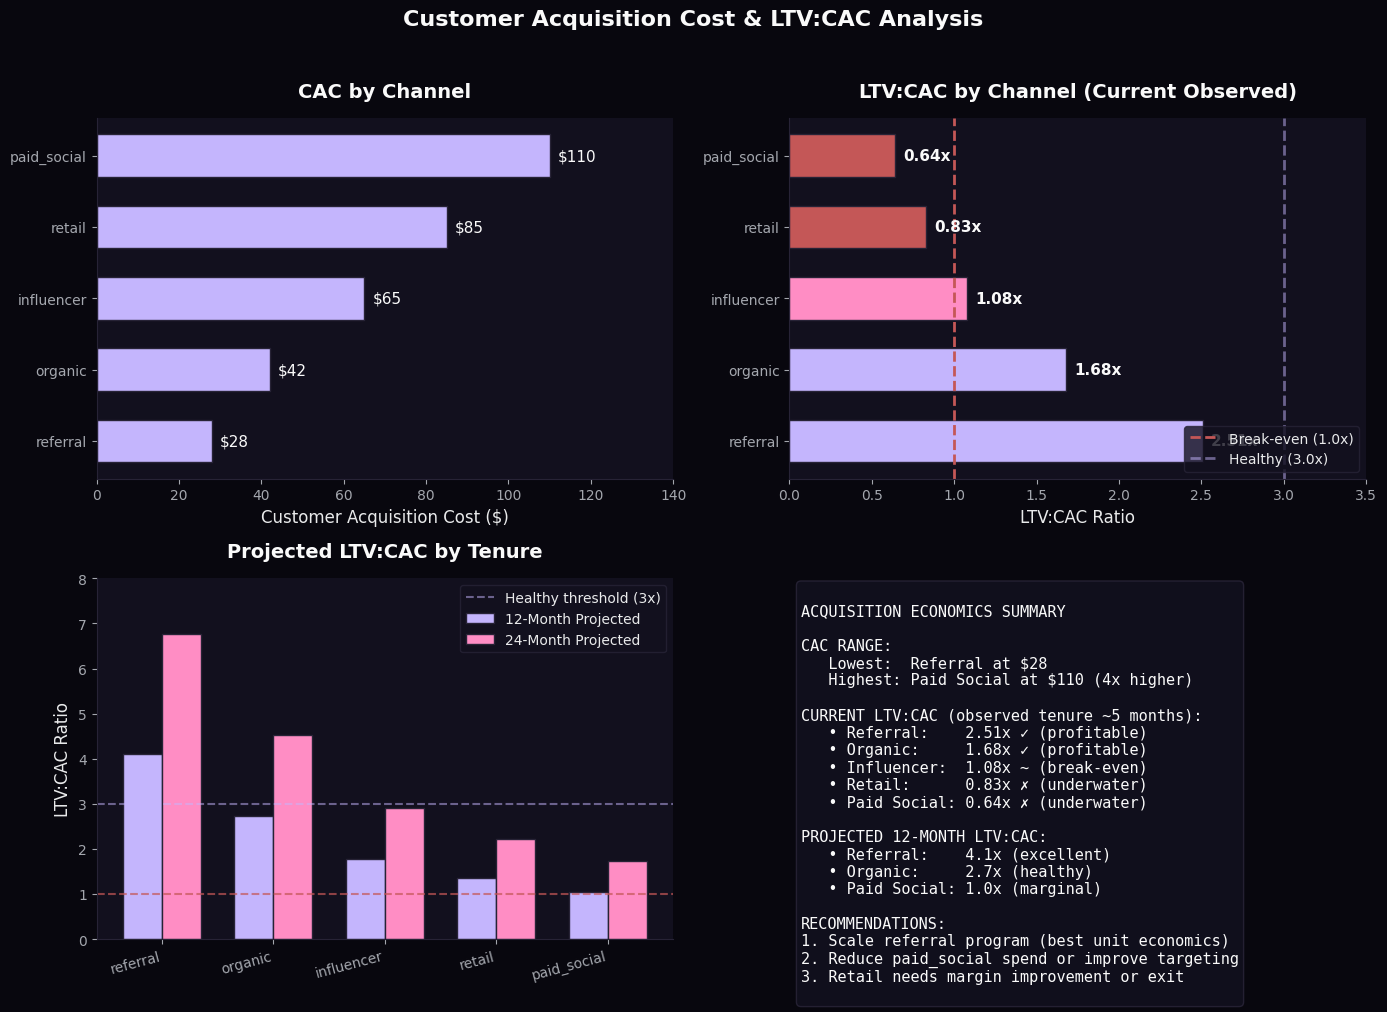

In [26]:
# Create comprehensive CAC and LTV:CAC visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

channels = ltv_cac['acquisition_channel'].values
colors_by_ratio = [CATEGORICAL_PALETTE[0] if r >= 1.5 else CATEGORICAL_PALETTE[1] if r >= 1.0 else '#c45757' 
                   for r in ltv_cac['ltv_cac_ratio']]

# 1. CAC by Channel
ax1 = axes[0, 0]
cac_sorted = cac_by_channel.sort_values('cac')
bars = ax1.barh(cac_sorted['channel'], cac_sorted['cac'], color=CATEGORICAL_PALETTE[0], height=0.6, edgecolor='#272336')
ax1.set_xlabel('Customer Acquisition Cost ($)')
ax1.set_title('CAC by Channel', fontweight='bold', pad=15)
for bar, val in zip(bars, cac_sorted['cac']):
    ax1.text(val + 2, bar.get_y() + bar.get_height()/2, f'${val:.0f}', va='center', fontsize=11)
ax1.set_xlim(0, 140)

# 2. LTV:CAC Ratio
ax2 = axes[0, 1]
bars = ax2.barh(channels, ltv_cac['ltv_cac_ratio'].values, color=colors_by_ratio, height=0.6, edgecolor='#272336')
ax2.axvline(x=1.0, color='#c45757', linestyle='--', linewidth=2, label='Break-even (1.0x)')
ax2.axvline(x=3.0, color=CATEGORICAL_PALETTE[0], linestyle='--', linewidth=2, alpha=0.5, label='Healthy (3.0x)')
ax2.set_xlabel('LTV:CAC Ratio')
ax2.set_title('LTV:CAC by Channel (Current Observed)', fontweight='bold', pad=15)
for bar, val in zip(bars, ltv_cac['ltv_cac_ratio']):
    ax2.text(val + 0.05, bar.get_y() + bar.get_height()/2, f'{val:.2f}x', va='center', fontsize=11, fontweight='bold')
ax2.legend(loc='lower right')
ax2.set_xlim(0, 3.5)

# 3. Projected LTV:CAC (12-month and 24-month)
ax3 = axes[1, 0]
x = np.arange(len(channels))
width = 0.35

ltv_12mo_cac = projected_12mo_ltv / ltv_cac['cac'].values
ltv_24mo_cac = projected_24mo_ltv / ltv_cac['cac'].values

bars1 = ax3.bar(x - width/2, ltv_12mo_cac, width, label='12-Month Projected', color=CATEGORICAL_PALETTE[0], edgecolor='#272336')
bars2 = ax3.bar(x + width/2, ltv_24mo_cac, width, label='24-Month Projected', color=CATEGORICAL_PALETTE[1], edgecolor='#272336')
ax3.axhline(y=3.0, color=CATEGORICAL_PALETTE[0], linestyle='--', alpha=0.5, label='Healthy threshold (3x)')
ax3.axhline(y=1.0, color='#c45757', linestyle='--', alpha=0.7)
ax3.set_ylabel('LTV:CAC Ratio')
ax3.set_title('Projected LTV:CAC by Tenure', fontweight='bold', pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(channels, rotation=15, ha='right')
ax3.legend(loc='upper right')
ax3.set_ylim(0, 8)

# 4. Key findings summary
ax4 = axes[1, 1]
ax4.axis('off')

best_channel = ltv_cac.iloc[0]['acquisition_channel']
worst_channel = ltv_cac.iloc[-1]['acquisition_channel']

summary_text = f"""
ACQUISITION ECONOMICS SUMMARY

CAC RANGE:
   Lowest:  Referral at \$28
   Highest: Paid Social at \$110 (4x higher)

CURRENT LTV:CAC (observed tenure ~5 months):
   • Referral:    2.51x ✓ (profitable)
   • Organic:     1.68x ✓ (profitable)
   • Influencer:  1.08x ~ (break-even)
   • Retail:      0.83x ✗ (underwater)
   • Paid Social: 0.64x ✗ (underwater)

PROJECTED 12-MONTH LTV:CAC:
   • Referral:    4.1x (excellent)
   • Organic:     2.7x (healthy)
   • Paid Social: 1.0x (marginal)

RECOMMENDATIONS:
1. Scale referral program (best unit economics)
2. Reduce paid_social spend or improve targeting
3. Retail needs margin improvement or exit
"""

ax4.text(0.02, 0.98, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336', alpha=0.9))

plt.suptitle('Customer Acquisition Cost & LTV:CAC Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()